#Import data dan Library

In [1]:
import tensorflow as tf
import sys 
import pandas as pd
import tensorflow
import sklearn as sk
import numpy as np
import re
import string

check_gpu = len(tf.config.list_physical_devices('GPU'))>0

In [2]:
dfb = pd.read_csv("/content/data_mentah_sebelum.csv")
dfb.head()

,Name,Comment,Time,Likes,Reply Count,language
0,Sarojo Wibowo,Bubarkan FPI,2020-12-16T11:32:45Z,1,0.0,id
1,Tembos Haka1,Negara ini yang miskin tambah miskin yg kaya t...,2020-12-15T21:55:22Z,0,0.0,id
2,rasya,"Bawang merah Bawang putih, yg jahat bawang mer...",2020-12-13T07:43:41Z,2,0.0,id
3,Hermansyah SAMSUL AIN,Cabang Usaha kerja..Alhamdulillah,2020-12-02T18:56:56Z,0,0.0,id
4,kampret bolobolo,Yes... sertifikasi halal gratis.. kemarin2 kan...,2020-11-21T11:45:35Z,0,0.0,id


In [3]:
dfa =pd.read_csv("/content/data_mentah_sesudah.csv")
dfa.head()

,Name,Comment,Time,Likes,Reply Count,language
0,Nandar Iskandar,Kerja 4 th boro boro di angkatttt pegawaiii ma...,2022-04-11T07:11:07Z,0,0.0,id
1,Aris Adicahyono,"Baca putusan mk dengan benar, setiap pelaksana...",2022-01-15T22:45:34Z,0,0.0,id
2,Teguh Drakula,Maaf pak saya telah mengganggu dengan masuk da...,2021-12-22T20:39:55Z,0,0.0,id
3,Presiden & Rakyat,Salam 3 periode jika Allah menghendaki dan rak...,2021-12-04T23:32:15Z,0,0.0,id
4,"Justin The Lawyer Manurung., SH",Kalau UU yg tdk baik (masih dlm proses perbaik...,2021-12-04T21:02:23Z,0,0.0,id


#Data Preprocessing

##Drop kolom tidak terpakai

In [4]:
dfb.drop(dfb.columns[[2,3,4,5]], axis=1, inplace=True)
dfa.drop(dfa.columns[[2,3,4,5]], axis=1, inplace=True)

In [5]:
dfb.head()

,Name,Comment
0,Sarojo Wibowo,Bubarkan FPI
1,Tembos Haka1,Negara ini yang miskin tambah miskin yg kaya t...
2,rasya,"Bawang merah Bawang putih, yg jahat bawang mer..."
3,Hermansyah SAMSUL AIN,Cabang Usaha kerja..Alhamdulillah
4,kampret bolobolo,Yes... sertifikasi halal gratis.. kemarin2 kan...


In [6]:
dfa.head()

,Name,Comment
0,Nandar Iskandar,Kerja 4 th boro boro di angkatttt pegawaiii ma...
1,Aris Adicahyono,"Baca putusan mk dengan benar, setiap pelaksana..."
2,Teguh Drakula,Maaf pak saya telah mengganggu dengan masuk da...
3,Presiden & Rakyat,Salam 3 periode jika Allah menghendaki dan rak...
4,"Justin The Lawyer Manurung., SH",Kalau UU yg tdk baik (masih dlm proses perbaik...


##Membuat fungsi untuk preprocess

In [7]:
dfb = dfb.astype(str)
dfa = dfa.astype(str)

# Implementasi Regular Expression untuk menghapus simbol dan emoji
def normalisasi(text):
  text = re.sub(r'@[A-za-z0-9]+', '', text) #removing @mentions
  text = re.sub('[0-9]+', '', text) #removing number
  text = re.sub(r'#', '', text) #removing '#' symbol
  text = re.sub(r'RT[\s]+', '', text) #removing RT
  text = re.sub(r'#', '', text) #removing '#' symbol
  text = re.sub(r'[\n]+', '', text) #remove new line
  text = re.sub(r"^\s+|\s+$", "", text) #remove leading and trailing spaces in a word using OR sign to delete both
  text = re.sub(r" +", " ", text) #remove multiple space betwen words
  text = re.sub(r'http\S+', '', text) #yang ini yang buat remove https
  text = re.sub(r"\b[a-zA-Z]\b", "", text) #removing single char
  text = re.sub('\s+', ' ', text) #removing multiple whitespace
  text = re.sub(r'\W', " ", text)
  text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', ' ')#remove tab, new line, and back slice
  text = re.sub(r'[^\w\s]', ' ', text) #remove puntuation $ emoji (remove all besides \w > word dan \s > space)
  text = re.sub(r"²|¹|³|⁰|ⁱ|⁴|⁵|⁶|⁷|⁸|⁹|⁺|⁻|⁽|⁾|ⁿ]+", "", text) #ilangin pangkat
  text = re.sub(r'_', '',text) #ilangin garisbawah
  text = text.translate(str.maketrans("", "", string.punctuation)) #ilangin punctuation(,:';)
  return text

# Fungsi menghapus karakter berulang
def replace_repeat_character(text):
    # Pattern to look for three or more repetitions of any character, including newlines (contoh goool -> gol).
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1", text)

# Merubah kata alay menjadi kata baku
dict = {row[0] : row[1] for _, row in pd.read_csv("/content/kbba.txt", delimiter = "\t").iterrows()}

def kbbi(text): 
    token = text.split()
    final_string = ' '.join(str(dict.get(word, word)) for word in token)
    return final_string

# Menghapus baris yang mengandung noise
def noise(text): 
    text = text.split()
    listStopword =  ['amp', 'tong', 'fry', 'vcs', 'bahh', 'a', 'wkwkwk',
                     'c', 'yeey', 'oi', 'pret', 'iya', 'nya', 'sih', 'mbok',
                     'ku', 'loh', 'lho', 'ah', 'nihh', 'mares', 'openbo',
                     'ya', 'hah', 'joss', 'deh''rmp', 'v', 'via', 'lha', 'mah', 'xixi',
                     'username', 'ilc','ilctvone','hitamputih', 'hitamputiht7','kickandy',
                     'metro','metrotv','at', 'kickandymetrotv','tvmatanajwa',
                     'matanajwametrotv','usermention','user','mention','providername',
                     'url','g','gb','yang','dan','nya','ya','smiling','ok','hand'
                     'provider','name','providername','andy','najwa','shihab','sihab', 'di',
                     'dan','ini','fpi','mikhayla','']
                     
    text = [w for w in text if not w in listStopword]
    text = " ".join(text)
    return text

#Stopword
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords=set(stopwords.words("indonesian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##preprocess data sebelum

In [8]:
# normalisasi
dfb['stopword_comment'] = dfb['Comment'].apply(lambda x: normalisasi(x))

# Merubah menjadi huruf kecil
dfb['stopword_comment'] = dfb['stopword_comment'].apply(lambda x: x.lower())

#hapus karakter berulang
dfb['stopword_comment'] = dfb['stopword_comment'].apply(replace_repeat_character) 

# KBBI
dfb['stopword_comment'] = dfb['stopword_comment'].apply(lambda x: kbbi(x))

#hapus noise
dfb['stopword_comment'] = dfb['stopword_comment'].apply(lambda x: noise(x))

#stopword
dfb['stopword_comment'] = dfb['stopword_comment'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stopwords)]))

#Duplikat
dfb = dfb.drop_duplicates(subset=['stopword_comment'])

#Drop Missing Value
dfb = dfb.dropna(subset=['stopword_comment'])

##preprocess data sesudah

In [9]:
# normalisasi
dfa['stopword_comment'] = dfa['Comment'].apply(lambda x: normalisasi(x))

# Merubah menjadi huruf kecil
dfa['stopword_comment'] = dfa['stopword_comment'].apply(lambda x: x.lower())

#hapus karakter berulang
dfa['stopword_comment'] = dfa['stopword_comment'].apply(replace_repeat_character) 

# KBBI
dfa['stopword_comment'] = dfa['stopword_comment'].apply(lambda x: kbbi(x))

#hapus noise
dfa['stopword_comment'] = dfa['stopword_comment'].apply(lambda x: noise(x))


#stopword
dfa['stopword_comment'] = dfa['stopword_comment'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stopwords)]))

#Duplikat
dfa = dfa.drop_duplicates(subset=['stopword_comment'])

#Drop Missing Value
dfa = dfa.dropna(subset=['stopword_comment'])

In [10]:
print(len(dfb))
print(len(dfa))

12792
552


In [11]:
dfa

,Name,Comment,stopword_comment
0,Nandar Iskandar,Kerja 4 th boro boro di angkatttt pegawaiii ma...,kerja boro boro angkat pegawai makan keringat ...
1,Aris Adicahyono,"Baca putusan mk dengan benar, setiap pelaksana...",baca putusan mk pelaksanan ciptakerja batal hukum
2,Teguh Drakula,Maaf pak saya telah mengganggu dengan masuk da...,maaf mengangu masuk komen chanel urgen beritah...
3,Presiden & Rakyat,Salam 3 periode jika Allah menghendaki dan rak...,salam periode allah rakyat mengharapkanternyat...
4,"Justin The Lawyer Manurung., SH",Kalau UU yg tdk baik (masih dlm proses perbaik...,proses perbaikan membutuhkan mk diberlakukan r...
...,...,...,...
565,NV007 CPC 🇮🇩,Lanjutkan kan Pakde... Sehat selalu,lanjutkan pakde sehat
566,sinto gendeng,bangkrut rakyat sengsara,bangkrut rakyat sengsara
567,Solihinbalakar Balakar,Sehat selalu pemimpin quu....,sehat pemimpin
568,nur h1dayah,Pin dong salam dari Malaysia. Di kedahhhhh sun...,pin salam malaysia kedah sungai petani darul aman


In [12]:
dfb

,Name,Comment,stopword_comment
0,Sarojo Wibowo,Bubarkan FPI,bubarkan
1,Tembos Haka1,Negara ini yang miskin tambah miskin yg kaya t...,negara miskin miskin kaya kaya bantuan negara ...
2,rasya,"Bawang merah Bawang putih, yg jahat bawang mer...",bawang merah bawang putih jahat bawang merah b...
3,Hermansyah SAMSUL AIN,Cabang Usaha kerja..Alhamdulillah,cabang usaha kerja alhamdulilah
4,kampret bolobolo,Yes... sertifikasi halal gratis.. kemarin2 kan...,yes sertifikasi halal gratis kemarin bayar bia...
...,...,...,...
13608,Rismat Group,Becanda doang yg gak d hoakin SMA rejim,becanda hoax rezim
13609,Ganden salam seduluran gaes,@Annisa Mikhayla lah nyta ya cipta kerja g ada...,nyata cipta kerja hilangin gaes main demo
13610,Surya1320,Semangat Terus Pak Jokowi Aku tau kau di takdi...,semangat jokowi takdirkan tuhan menyelamatkan ...
13611,swa puti,Bener mas e...tdk mungkin presiden mau nyusahi...,mas presiden nyusahin rakyatnya dasar pembenci...


#Visualisasi Data

##Wordcloud data sebelum

In [13]:
import matplotlib.pyplot
import seaborn as sns

comment_words=''

for val in dfb.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

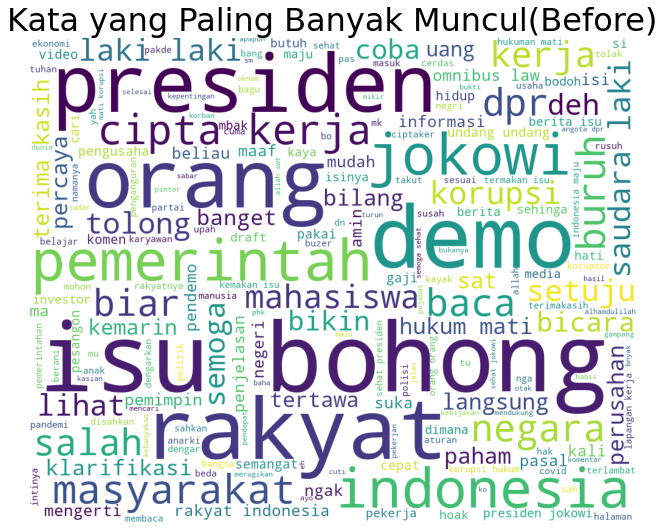

In [14]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud1 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("Kata yang Paling Banyak Muncul(Before)", fontsize = 32)
plt.tight_layout(pad = 1) 
  
plt.show() 

##Wordcloud data sesudah

In [15]:
comment_words=''

for val in dfa.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

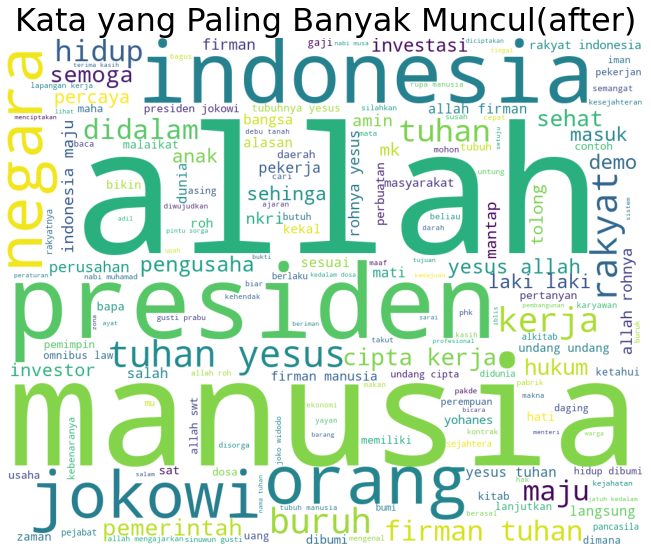

In [16]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud2 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("Kata yang Paling Banyak Muncul(after)", fontsize = 32)
plt.tight_layout(pad = 1) 
  
plt.show() 

#Visualisasi sentimen


##load data train

In [17]:
# Memasukan dataset untuk train
df2 = pd.read_csv('/content/dataset labelled uuck github - Sheet1.csv')

In [18]:
df2.head()

,Sentiment,Text
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegugu...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


##preprocess data train

In [19]:
# normalisasi
df2['cleaned_comment'] = df2['Text'].apply(lambda x: normalisasi(x))

# Merubah menjadi huruf kecil
df2['cleaned_comment'] = df2['cleaned_comment'].apply(lambda x: x.lower())

#hapus karakter berulang
df2['cleaned_comment'] = df2['cleaned_comment'].apply(replace_repeat_character) 

#hapus noise
df2['cleaned_comment'] = df2['cleaned_comment'].apply(lambda x: noise(x))

# KBBI
df2['cleaned_comment'] = df2['cleaned_comment'].apply(lambda x: kbbi(x))

In [20]:
df2.head()

,Sentiment,Text,cleaned_comment
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegugu...,tolol tidak ada hubungan keguguran dengan paka...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,goblok kamu tata cowo banget dibelain balikan ...
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin nangis sekarang lengket lagi aduh kok ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesal dengan gausah ke anaknya j...
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",aduh perempuan itu lagi sakit jiwa kenapa haru...


##visualisasi Perbandingan Sentimen data train

In [21]:
senti_count = df2['Sentiment'].value_counts()
print(type(senti_count))
print(senti_count)

<class 'pandas.core.series.Series'>
negative    586
positive    559
Name: Sentiment, dtype: int64


In [22]:
senti_count2=list(zip(str(senti_count),str(senti_count.index)))
senti_count2=tuple(zip(senti_count,senti_count.index))
kolom=[(sub[1], sub[0]) for sub in senti_count2]
kolom

[('negative', 586), ('positive', 559)]

In [23]:
labels=[]
values=[]
for row in kolom:
    labels.append(row[0])
    values.append(row[1])
print(labels)
print(values)

['negative', 'positive']
[586, 559]


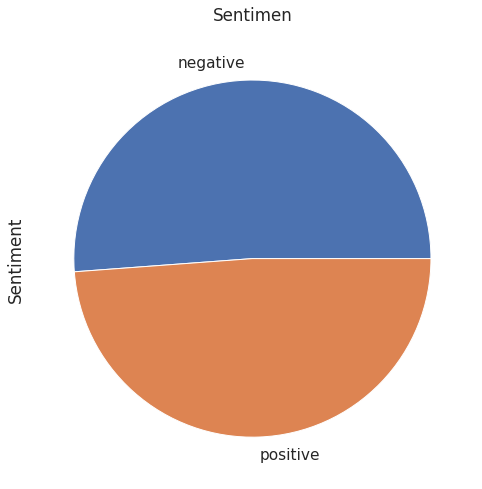

In [24]:
sns.set(font_scale=1.4)
senti_count.plot(kind='pie', figsize=(8, 10))#, rot=0)
plt.title("Sentimen", y=1.02);

##Label encoder untuk sentimen positif dan negatif

In [25]:
from sklearn.preprocessing import LabelEncoder

# Menggunakan one hot encoding untuk merubah kolom sentiment menjadi kategorikal
#sentimen = pd.get_dummies(df2.Sentiment,prefix='Sentiment')
#df2 = pd.concat([df2,sentimen], axis=1)
labelencoder = LabelEncoder()
df2['Sentiment'] = labelencoder.fit_transform(df2['Sentiment'])

df2

,Sentiment,Text,cleaned_comment
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegugu...,tolol tidak ada hubungan keguguran dengan paka...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......,goblok kamu tata cowo banget dibelain balikan ...
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin nangis sekarang lengket lagi aduh kok ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesal dengan gausah ke anaknya j...
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",aduh perempuan itu lagi sakit jiwa kenapa haru...
...,...,...,...
1140,1,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yan...",pantesan lancar sinyal lancar sekali lombok timur
1141,1,Alhamdulillah lancar pakai <PROVIDER_NAME>,alhamdulilah lancar pakai
1142,1,"Untung pakai internet <PROVIDER_NAME>, lancar,...",untung pakai internet lancar jadi dapat banyak...
1143,1,"di tempat ramai seperti di lokasi wisata, <PRO...",tempat ramai seperti lokasi wisata tetap jaya


In [26]:
comment_sentimen = df2['cleaned_comment'].values
label = df2[['Sentiment']].values

#Data Splitting

In [27]:
# Membagi data menjadi 80% data train dan 20% data test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(comment_sentimen, label, test_size=0.2)

##Tokenizing

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer # Mengimport tokenizer untuk preprocessing kata-kata
from tensorflow.keras.preprocessing.sequence import pad_sequences # Mengimport pad_sequences untuk preprocessing kata

# Memasukkan fungsi tokenizer yang didalamnya terdapat parameter untuk menyimpan 4500 kata yang sering muncul
tokenizer = Tokenizer(num_words=4500, oov_token='-')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)

# Memasukkan data train dan test ke dalam sequence
sekuens_latih = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)

# Menggunakan padding agar sequence menjadi sama panjang
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [29]:
tokenIndexKata=tokenizer.word_index
print(tokenIndexKata)

{'-': 1, 'tidak': 2, 'yang': 3, 'orang': 4, 'saya': 5, 'saja': 6, 'banget': 7, 'sudah': 8, 'jadi': 9, 'kalau': 10, 'sama': 11, 'ada': 12, 'itu': 13, 'kamu': 14, 'dia': 15, 'dari': 16, 'tapi': 17, 'lagi': 18, 'juga': 19, 'pakai': 20, 'bisa': 21, 'anak': 22, 'dengan': 23, 'mata': 24, 'keren': 25, 'mbak': 26, 'semoga': 27, 'lebih': 28, 'karena': 29, 'selalu': 30, 'apa': 31, 'banyak': 32, 'buat': 33, 'punya': 34, 'memang': 35, 'cantik': 36, 'jangan': 37, 'ke': 38, 'si': 39, 'pak': 40, 'seperti': 41, 'baik': 42, 'masih': 43, 'sangat': 44, 'suka': 45, 'ini': 46, 'hitam': 47, 'kita': 48, 'kaya': 49, 'artis': 50, 'putih': 51, 'mau': 52, 'deh': 53, 'untuk': 54, 'kok': 55, 'nonton': 56, 'lihat': 57, 'bukan': 58, 'hitamputiht': 59, 'bagus': 60, 'acara': 61, 'dapat': 62, 'akan': 63, 'cuma': 64, 'indonesia': 65, 'ibu': 66, 'jaringan': 67, 'kan': 68, 'terus': 69, 'allah': 70, 'sekarang': 71, 'makin': 72, 'begitu': 73, 'tahu': 74, 'kenapa': 75, 'boikot': 76, 'bikin': 77, 'sm': 78, 'sinyal': 79, 'seha

In [30]:
sampel_data=['apa saja deh terserah',
            'terserah kamu saja, aku ga paham']
tokenizer2 = Tokenizer(num_words=100, oov_token='-')
tokenizer2.fit_on_texts(sampel_data)
tokenIndexKata=tokenizer2.word_index

sekuens_sampel = tokenizer2.texts_to_sequences(sampel_data)

padded_sampel = pad_sequences(sekuens_sampel)

print(tokenIndexKata)
print(sekuens_sampel)
print(padded_sampel)

{'-': 1, 'saja': 2, 'terserah': 3, 'apa': 4, 'deh': 5, 'kamu': 6, 'aku': 7, 'ga': 8, 'paham': 9}
[[4, 2, 5, 3], [3, 6, 2, 7, 8, 9]]
[[0 0 4 2 5 3]
 [3 6 2 7 8 9]]


#Modeling

##Membuat callback dan checkpoint

In [31]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pickle5 as pickle
with open('tokenizer2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# Membuat kelas dan fungsi agar proses training berhenti saat akurasi validasi model telah mencapai 83%
class myCallBack(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.83):
            print("\nAkurasi validasi telah mencapai > 83%!")
            self.model.stop_training = True
myCallBack = myCallBack()

In [34]:
import os 
from tensorflow.keras.callbacks import ModelCheckpoint

# Fungsi untuk menyimpan model "C:\Users\Alfa\Program Skripsi\kesehatan_fix_blom_fix.csv"
save_direc = os.path.join(os.getcwd(), 'drive/My Drive/Sentimen Analisis/')

model_name = 'geaNlp_weight_model2.h5'
model_name2 = 'geaNlp_weight_model3.h5'

# Membuat directory untuk menyimpan model
if not os.path.isdir(save_direc):
    os.makedirs(save_direc)

# Menggabungkan directory dengan model
modelpath = os.path.join(save_direc, model_name2)

checkpoint = ModelCheckpoint(filepath = modelpath, verbose = 2, monitor='val_accuracy',
                             save_best_only = True, save_weights_only = True)#,save_freq=1)

##Membuat Model Arsitektur jaringan

In [35]:
from tensorflow.keras import regularizers # Library untuk mencegah overfitting pada model
from tensorflow.keras.optimizers import RMSprop # mengimport optimizer untuk model

# Membuat model Sequential dengan Bidirectional LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4500, 32), # 4500 input & 32 layer embedding
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),#64 layer Bi-LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #32 layer Bi-LSTM
    tf.keras.layers.Dense(64, activation='relu'), #64 layer dense dengan relu activation
    tf.keras.layers.Dropout(0.5), # Menggunakan dropout agar model tidak overfitting
    tf.keras.layers.Dense(1, activation='sigmoid') # Outputnya adalah 1 dan karena binary menggunakan aktivasi sigmoid
])

model.summary() # Melihat shape dan parameter model
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), # Menggunakan optimizer RMSprop dengan learning rate 0.0001
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          144000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

##Training Model

In [36]:
#batch_size = 16
history = model.fit(padded_latih, y_train, 
                    validation_data=(padded_test, y_test), 
                    epochs=25, #batch_size=10,
                    steps_per_epoch= 30,
                    callbacks=[myCallBack, checkpoint],
                    verbose=2)

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.50655, saving model to /content/drive/My Drive/Sentimen Analisis/geaNlp_weight_model3.h5
30/30 - 23s - loss: 0.6931 - accuracy: 0.5229 - val_loss: 0.6931 - val_accuracy: 0.5066 - 23s/epoch - 783ms/step
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.50655
30/30 - 8s - loss: 0.6924 - accuracy: 0.5633 - val_loss: 0.6929 - val_accuracy: 0.5022 - 8s/epoch - 270ms/step
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.50655
30/30 - 8s - loss: 0.6920 - accuracy: 0.5393 - val_loss: 0.6926 - val_accuracy: 0.4978 - 8s/epoch - 276ms/step
Epoch 4/25

Epoch 4: val_accuracy improved from 0.50655 to 0.51528, saving model to /content/drive/My Drive/Sentimen Analisis/geaNlp_weight_model3.h5
30/30 - 5s - loss: 0.6898 - accuracy: 0.5786 - val_loss: 0.6920 - val_accuracy: 0.5153 - 5s/epoch - 163ms/step
Epoch 5/25

Epoch 5: val_accuracy improved from 0.51528 to 0.53275, saving model to /content/drive/My Drive/Sentimen Analisis/geaNl

In [37]:
# Save model yang telah dijalankan
#model.save("lstmModel1.h5")

##Grafik Performa Training model

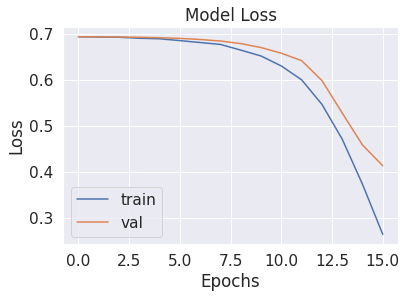

In [38]:
# Menampilkan plot loss dari model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

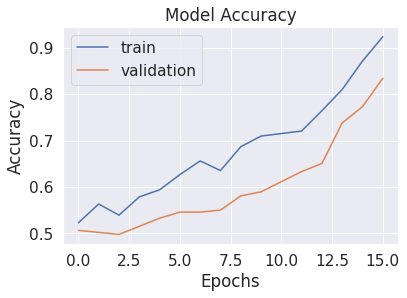

In [39]:
# Menampilkan plot akurasi dari model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Model Evaluation

In [40]:
loss, acc = model.evaluate(padded_test, y_test, verbose=1)
                            #batch_size=batch_size)
print("loss:", loss)
print("Validation accuracy:", acc)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

8/8 [==============================] - 0s 51ms/step - loss: 0.4133 - accuracy: 0.8341
loss: 0.4132640063762665
Validation accuracy: 0.8340611457824707
Restored model, accuracy: 83.41%


##classification Repot dan confussion matrix

In [41]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score, f1_score, recall_score

def model_evaluate():
  predict_y = model.predict(padded_test)
  y_predict = (predict_y > 0.5).astype(int)
  
  print(classification_report(y_test, y_predict.round()))
  print(f"Accuracy: {round(accuracy_score(y_test, y_predict), 2)}") 
  print(f"Precision: {round(precision_score(y_test, y_predict), 2)}")
  print(f"Recall: {round(recall_score(y_test, y_predict), 2)}")
  print(f"F1_score: {round(f1_score(y_test, y_predict), 2)}")
  
  confmat = confusion_matrix(y_test, y_predict)
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.tight_layout()

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       115
           1       0.86      0.80      0.83       114

    accuracy                           0.83       229
   macro avg       0.84      0.83      0.83       229
weighted avg       0.84      0.83      0.83       229

Accuracy: 0.83
Precision: 0.86
Recall: 0.8
F1_score: 0.83


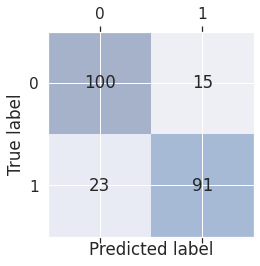

In [42]:
model_evaluate()

##Mencoba ke Kata baru

In [43]:
yt = ['Peraturan sampah, bangkrut rakyat sengsara']
print(yt)
#vectorizing the comment  by the pre-fitted tokenizer instance
yt = tokenizer.texts_to_sequences(yt)
#padding the comment to have exactly the same shape as `embedding_2` input
yt = pad_sequences(yt, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(yt)
print(sentiment)
print(np.rint(sentiment))

if(np.rint(sentiment) == 0):
    print('Sentimen: Negatif')
else :
    print('Sentimen: Positif')

['Peraturan sampah, bangkrut rakyat sengsara']
[[0.18491334]]
[[0.]]
Sentimen: Negatif


In [44]:
ytb = ['alhamdulillah, sehat selalu pak']
print(ytb)
#vectorizing the comment  by the pre-fitted tokenizer instance
ytb = tokenizer.texts_to_sequences(ytb)
#padding the comment to have exactly the same shape as `embedding_2` input
ytb = pad_sequences(ytb, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(ytb)
print(sentiment)
print(np.rint(sentiment))

if(np.rint(sentiment) == 0):
    print('Sentimen: Negatif')
else :
    print('Sentimen: Positif')

['alhamdulillah, sehat selalu pak']
[[0.8937221]]
[[1.]]
Sentimen: Positif


In [45]:
def convert(text):
  yt = [text]
  yt = tokenizer.texts_to_sequences(yt)
  yt = pad_sequences(yt, maxlen=29, dtype='int32', value=0)
  sentiment = model.predict(yt)
  if(np.rint(sentiment) == 0):
      return 'Negatif'
  else :
     return 'Positif'

#Sebelum Pengesahan

In [46]:
data_sebelum = dfb
data_sebelum['Hasil Sentimen'] = data_sebelum['stopword_comment'].apply(lambda x: convert(x))

In [66]:
data_sebelum.tail(7)

,Name,Comment,stopword_comment,Hasil Sentimen
13606,Ganden salam seduluran gaes,maaf kan rakyatmu ini pk yang kemakn hoax pk,maaf rakyatmu penjahat kelamin kemakn isu boho...,Negatif
13607,uwak atok,rezim yg hoax rakyat d permak,rezim isu bohong rakyat permak,Negatif
13608,Rismat Group,Becanda doang yg gak d hoakin SMA rejim,becanda hoax rezim,Negatif
13609,Ganden salam seduluran gaes,@Annisa Mikhayla lah nyta ya cipta kerja g ada...,nyata cipta kerja hilangin gaes main demo,Negatif
13610,Surya1320,Semangat Terus Pak Jokowi Aku tau kau di takdi...,semangat jokowi takdirkan tuhan menyelamatkan ...,Positif
13611,swa puti,Bener mas e...tdk mungkin presiden mau nyusahi...,mas presiden nyusahin rakyatnya dasar pembenci...,Negatif
13613,Bunny,Semoga Allah selalu melindungi my president.. ...,semoga allah melindungi presiden amin,Positif


## Visualisasi Sentimen (data sebelum)

In [67]:
senti_count = data_sebelum['Hasil Sentimen'].value_counts()
print(type(senti_count))
print(senti_count)

<class 'pandas.core.series.Series'>
Negatif    9025
Positif    3767
Name: Hasil Sentimen, dtype: int64


In [49]:
senti_count2=list(zip(str(senti_count),str(senti_count.index)))
senti_count2=tuple(zip(senti_count,senti_count.index))
kolom=[(sub[1], sub[0]) for sub in senti_count2]
kolom

[('Negatif', 9025), ('Positif', 3767)]

In [50]:
labels=[]
values=[]
for row in kolom:
    labels.append(row[0])
    values.append(row[1])
print(labels)
print(values)

['Negatif', 'Positif']
[9025, 3767]


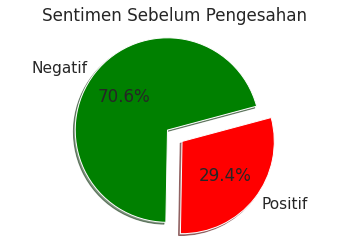

In [51]:
my_labels = 'Negatif','Positif'
my_colors = ['green','red']
my_explode = (0.1, 0.1)
plt.pie(senti_count, labels=my_labels, autopct='%1.1f%%', 
        startangle=15, shadow = True, colors=my_colors, 
        explode=my_explode)
plt.title('Sentimen Sebelum Pengesahan')
plt.axis('equal')
plt.show()

In [52]:
data_sebelum.to_csv('data_sebelum_sentimen.csv')

##Wordcloud sentimen positif (data sebelum)

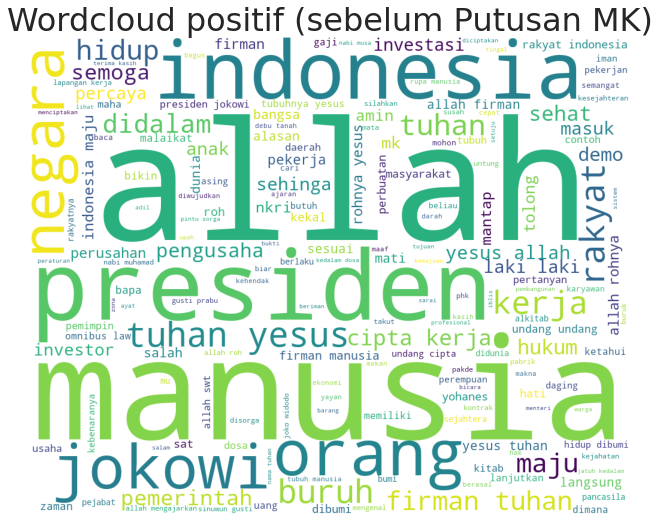

In [53]:
labeled = pd.read_csv('/content/data_sebelum_sentimen.csv')
# split df - positive and negative sentiment:
positive = labeled[labeled['Hasil Sentimen'] == 'Positif']
negative = labeled[labeled['Hasil Sentimen'] == 'Negatif']

comment_words=''

for val in positive.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("Wordcloud positif (sebelum Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 
  
plt.show() 

##Wordcloud sentimen negatif (data sebelum)

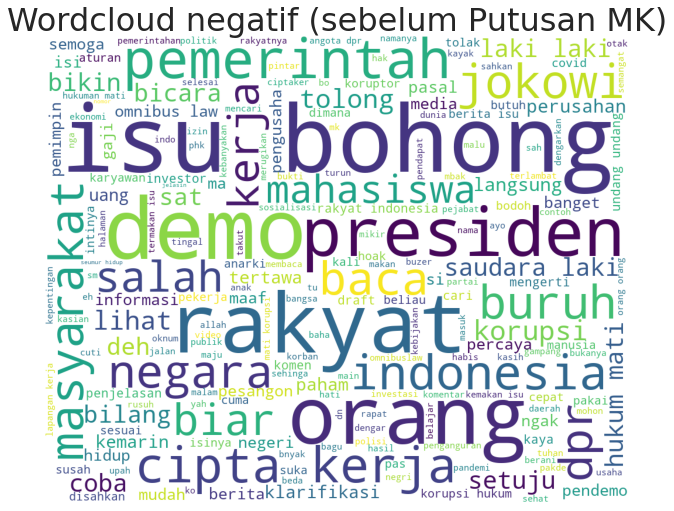

In [54]:
comment_words=''

for val in negative.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud4 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("Wordcloud negatif (sebelum Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 
  
plt.show() 

#Sesudah pengesahan

In [55]:
data_sesudah = dfa
data_sesudah['Hasil Sentimen'] =data_sesudah['stopword_comment'].apply(lambda x: convert(x))

In [56]:
data_sesudah

,Name,Comment,stopword_comment,Hasil Sentimen
0,Nandar Iskandar,Kerja 4 th boro boro di angkatttt pegawaiii ma...,kerja boro boro angkat pegawai makan keringat ...,Negatif
1,Aris Adicahyono,"Baca putusan mk dengan benar, setiap pelaksana...",baca putusan mk pelaksanan ciptakerja batal hukum,Negatif
2,Teguh Drakula,Maaf pak saya telah mengganggu dengan masuk da...,maaf mengangu masuk komen chanel urgen beritah...,Negatif
3,Presiden & Rakyat,Salam 3 periode jika Allah menghendaki dan rak...,salam periode allah rakyat mengharapkanternyat...,Negatif
4,"Justin The Lawyer Manurung., SH",Kalau UU yg tdk baik (masih dlm proses perbaik...,proses perbaikan membutuhkan mk diberlakukan r...,Negatif
...,...,...,...,...
565,NV007 CPC 🇮🇩,Lanjutkan kan Pakde... Sehat selalu,lanjutkan pakde sehat,Positif
566,sinto gendeng,bangkrut rakyat sengsara,bangkrut rakyat sengsara,Negatif
567,Solihinbalakar Balakar,Sehat selalu pemimpin quu....,sehat pemimpin,Positif
568,nur h1dayah,Pin dong salam dari Malaysia. Di kedahhhhh sun...,pin salam malaysia kedah sungai petani darul aman,Negatif


##Visualisasi Sentimen (data sesudah)

In [57]:
senti_count = data_sesudah['Hasil Sentimen'].value_counts()
print(type(senti_count))
print(senti_count)

<class 'pandas.core.series.Series'>
Negatif    355
Positif    197
Name: Hasil Sentimen, dtype: int64


In [58]:
senti_count2=list(zip(str(senti_count),str(senti_count.index)))
senti_count2=tuple(zip(senti_count,senti_count.index))
kolom=[(sub[1], sub[0]) for sub in senti_count2]
kolom

[('Negatif', 355), ('Positif', 197)]

In [59]:
labels=[]
values=[]
for row in kolom:
    labels.append(row[0])
    values.append(row[1])
print(labels)
print(values)

['Negatif', 'Positif']
[355, 197]


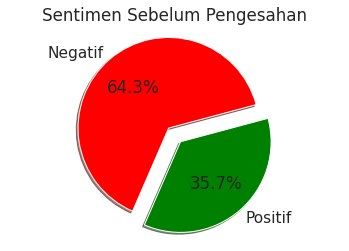

In [60]:
my_labels = 'Negatif','Positif'
my_colors = ['red','green']
my_explode = (0.1, 0.1)
plt.pie(senti_count, labels=my_labels, autopct='%1.1f%%', 
        startangle=15, shadow = True, colors=my_colors, 
        explode=my_explode)
plt.title('Sentimen Sebelum Pengesahan')
plt.axis('equal')
plt.show()

In [61]:
data_sesudah.to_csv('data_sesudah_sentimen.csv')

##Wordcloud sentimen positif (data sesudah)

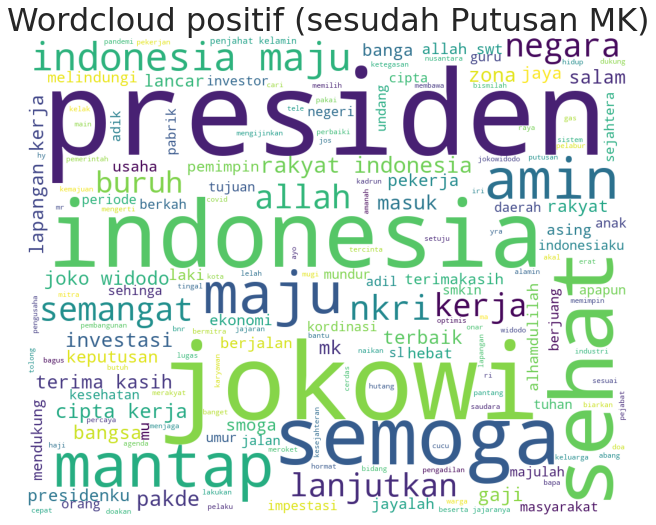

In [62]:
labeled1 = pd.read_csv('/content/data_sesudah_sentimen.csv')
# split df - positive and negative sentiment:
positive = labeled1[labeled1['Hasil Sentimen'] == 'Positif']
negative = labeled1[labeled1['Hasil Sentimen'] == 'Negatif']

comment_words=''

for val in positive.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud5 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud5) 
plt.axis("off") 
plt.title("Wordcloud positif (sesudah Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 
  
plt.show() 

##Wordcloud sentimen negatif (data sesudah)

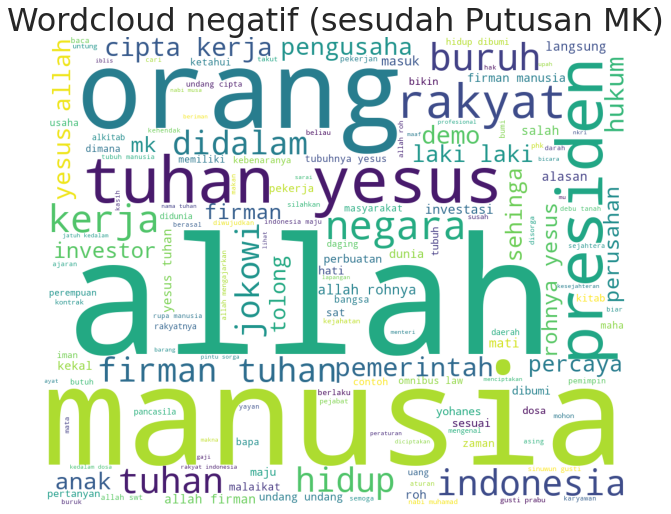

In [68]:
comment_words=''

for val in negative.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud6 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud6) 
plt.axis("off") 
plt.title("Wordcloud negatif (sesudah Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 
  
plt.show() 